# Imports

In [1]:
import numpy as np
import scipy
import pandas as pd
import requests
from os import makedirs, path, listdir, remove
from bs4 import BeautifulSoup, SoupStrainer
import zipfile as zpf
from shutil import rmtree
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize
import matplotlib
from matplotlib import cm
from datetime import datetime

import httplib2
import geopandas as gpd
from tqdm import tqdm
from typing import Tuple, List, Optional, Union

from graph_utils import *


## Load LAQN Data

In [6]:
species = "PM10" # "NO2"
region = "London"
start_date = "1996-01-01"
end_date = "2021-01-01"
data_folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code"
data_filename = f"LAQN_{species}_{start_date}_{end_date}.csv"

In [7]:
# Load LAQN data
laqn_df = pd.read_csv(path.join(data_folder, data_filename), index_col="date", infer_datetime_format=True)
print(laqn_df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code/LAQN_PM10_1996-01-01_2021-01-01.csv'

# Quantify missing data

Count including NaN values: 18224895
Count excluding NaN values: 16244172
Percentage of non-NaN values: 89.13177277564563
Percentage of non-NaN values per station:
Station
TD0      94.595521
BG3      95.191908
BG1      85.999144
BG2      82.730302
BN2      92.931986
           ...    
WM8      96.542390
WM9      68.101681
VS1      77.223712
CE2     100.000000
date    100.000000
Length: 202, dtype: float64


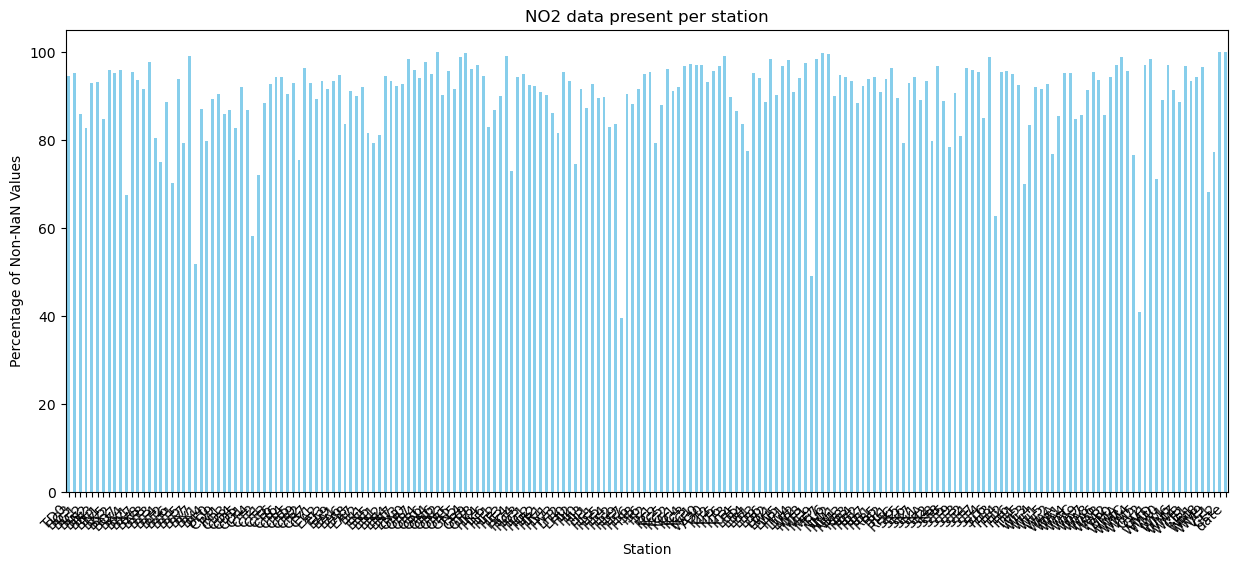

In [5]:
# Make sure the 'date' column is in datetime format
laqn_df['date'] = pd.to_datetime(laqn_df.index)

# Create a DataFrame to store the start and end dates for each station
station_dates = pd.DataFrame(index=laqn_df.columns, columns=['start_date', 'end_date'])

# Iterate over each station to find the start and end dates
for station in laqn_df.columns:
    # Find the first non-NaN date for the station
    start_date = laqn_df[station].first_valid_index()
    
    # Find the last non-NaN date for the station
    end_date = laqn_df[station].last_valid_index()
    
    # Store the start and end dates in the station_dates DataFrame
    station_dates.at[station, 'start_date'] = start_date
    station_dates.at[station, 'end_date'] = end_date

# Create two masks for each station based on the start and end dates
mask_include_nan = pd.DataFrame(index=laqn_df.index, columns=laqn_df.columns, dtype=bool)
mask_exclude_nan = pd.DataFrame(index=laqn_df.index, columns=laqn_df.columns, dtype=bool)

for station in laqn_df.columns:
    start_date = station_dates.at[station, 'start_date']
    end_date = station_dates.at[station, 'end_date']
    
    # Set True for the period between start and end dates, including NaN values
    mask_include_nan[station] = (laqn_df['date'] >= start_date) & (laqn_df['date'] <= end_date)
    
    # Set True for the period between start and end dates, excluding NaN values
    mask_exclude_nan[station] = (laqn_df['date'] >= start_date) & (laqn_df['date'] <= end_date) & laqn_df[station].notna()

# Count the number of datapoints using the masks for commissioning period
count_include_nan = mask_include_nan.sum().sum()
count_exclude_nan = mask_exclude_nan.sum().sum()

# Display the results
print("Count including NaN values:", count_include_nan)
print("Count excluding NaN values:", count_exclude_nan)
print("Percentage of non-NaN values:", (count_exclude_nan / count_include_nan) * 100)

# Calculate the number of non-NaN datapoints for each station using the masks
per_station_count_include_nan = mask_include_nan.sum()
per_station_count_exclude_nan = mask_exclude_nan.sum()

# Calculate the percentage of non-NaN values for each station
percentage_per_station = (per_station_count_exclude_nan / per_station_count_include_nan) * 100

# Display the results
print("Percentage of non-NaN values per station:")
print(percentage_per_station)

# Set index as the station names
percentage_per_station.index.name = 'Station'

# Plot the bar chart
ax = percentage_per_station.plot(kind='bar', figsize=(15, 6), color='skyblue')
ax.set_ylabel('Percentage of Non-NaN Values')
ax.set_title(f'{species} data present per station')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


(33, 10)


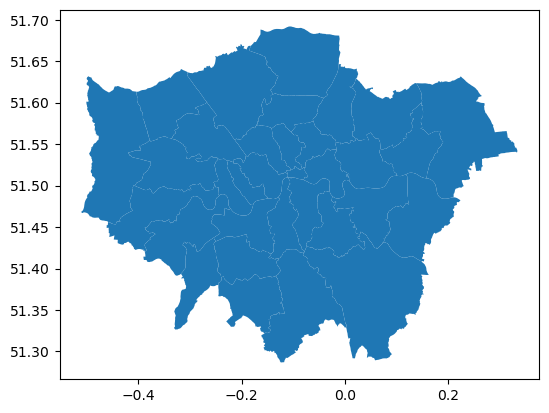

In [ ]:
# Load map file
folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code/Andrea_data/shape_files/london_boroughs"
london_boroughs_gdf = gpd.read_file(path.join(folder, "london_boroughs_coordinates.shp"))
#london_gdf = london_boroughs_gdf.dissolve()
print(london_boroughs_gdf.shape)
london_boroughs_gdf.plot()
plt.show()

In [ ]:
# Load LAQN metadata
folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code/Andrea_data/shape_files/LAQN_sites"
london_sites_gdf = gpd.read_file(path.join(folder, "LAQN_sites.shp"))
print(london_sites_gdf.shape)
# london_sites_gdf.plot()
# plt.show() 
print(london_sites_gdf.head())

(248, 17)
  @LocalAuth            @LocalAu_1 @SiteCode  \
0         27              Richmond       TD0   
1          1  Barking and Dagenham       BG3   
2          1  Barking and Dagenham       BG1   
3          1  Barking and Dagenham       BG2   
4          2                Barnet       BN2   

                                    @SiteName         @SiteType  \
0  - National Physical Laboratory, Teddington          Suburban   
1         Barking and Dagenham - North Street          Kerbside   
2           Barking and Dagenham - Rush Green          Suburban   
3       Barking and Dagenham - Scrattons Farm          Suburban   
4                           Barnet - Finchley  Urban Background   

            @DateClose           @DateOpene         @Latitude  \
0  2018-01-01 00:00:00  1996-08-08 00:00:00  51.4243043441456   
1  2011-05-25 00:00:00  2007-03-16 00:00:00         51.540444   
2                 None  1999-11-02 00:00:00         51.563752   
3                 None  1999-10-17 00: